# Confusion Matrix

## Semantic segmentation is essentially pixel-level classification. For a test image with dimensions 512x512, there are a total of 512*512 pixels. The classification results can be visualized using a confusion matrix.

## Below is the code that summarizes the classification results for all pixels across 288 images in the test dataset


In [21]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [22]:
# Paths to test dataset
TEST_IMAGES_DIR = 'dataset/test/images'
TEST_MASKS_DIR = 'dataset/test/masks'

# Load the saved model
model = tf.keras.models.load_model('deeplabv3_model.h5',
                                   custom_objects={'MeanIoU': tf.keras.metrics.MeanIoU})

# Parameters for the test set
IMG_HEIGHT, IMG_WIDTH = 512, 512

# Function to preprocess images and masks
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

def preprocess_mask(mask_path, target_size):
    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
    mask = np.where(mask > 0.5, 1, 0)  # Binarize
    return mask.squeeze()  # Remove single channel dimension

# Evaluate on the test set
def evaluate_model_with_confusion_matrix(model, test_images_dir, test_masks_dir):
    image_filenames = os.listdir(test_images_dir)
    all_predictions = []
    all_ground_truths = []

    for file_name in image_filenames:
        # Preprocess image and mask
        image_path = os.path.join(test_images_dir, file_name)
        mask_path = os.path.join(test_masks_dir, file_name.replace('.jpg', '.png'))

        image = preprocess_image(image_path, (IMG_HEIGHT, IMG_WIDTH))
        ground_truth = preprocess_mask(mask_path, (IMG_HEIGHT, IMG_WIDTH))

        # Predict mask
        prediction = model.predict(image)
        prediction = (prediction.squeeze() > 0.5).astype(np.uint8)  # Threshold prediction

        all_predictions.append(prediction.flatten())
        all_ground_truths.append(ground_truth.flatten())

    # Flatten all predictions and ground truths
    all_predictions = np.concatenate(all_predictions)
    all_ground_truths = np.concatenate(all_ground_truths)

    # Compute accuracy and IoU
    accuracy = accuracy_score(all_ground_truths, all_predictions)
    iou = jaccard_score(all_ground_truths, all_predictions, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_ground_truths, all_predictions, labels=[0, 1])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Landfill"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Pixel Classification Confusion Matrix")
    plt.show()


1/1 [==============================] - 0s 27ms/step
Accuracy: 0.9503
IoU: 0.6854


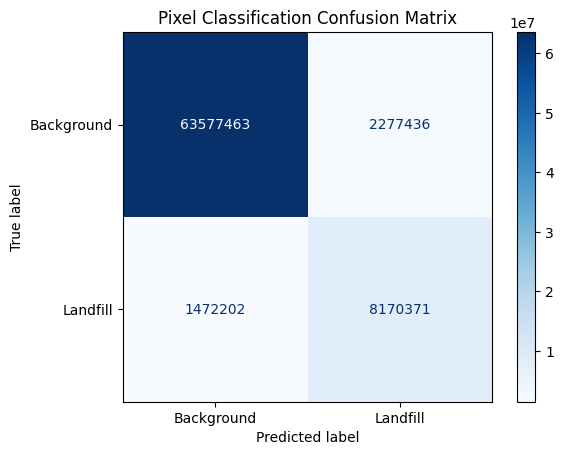

In [23]:
# Run evaluation with confusion matrix
evaluate_model_with_confusion_matrix(model, TEST_IMAGES_DIR, TEST_MASKS_DIR)

# Example Visulization
### Visualize sample images from the test set to demonstrate the model's practical application. The visualization includes three types of figures:

### 1.Input Image

### 2.Ground Truth Mask

### 3.Predicted Mask

In [20]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

In [15]:
# Paths
MODEL_PATH = 'deeplabv3_model.h5'

# Create results directory if not exists
os.makedirs(RESULT_DIR, exist_ok=True)

# Input image dimensions
IMG_HEIGHT, IMG_WIDTH = 512, 512

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'MeanIoU': tf.keras.metrics.MeanIoU})

In [16]:
# Create results directory if not exists
os.makedirs(RESULT_DIR, exist_ok=True)

# Input image dimensions
IMG_HEIGHT, IMG_WIDTH = 512, 512

# Function to preprocess the input image
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to save and display results
def save_and_display_results(model, image_path, mask_path, result_dir, target_size):
    # Preprocess the input image
    input_image = preprocess_image(image_path, target_size)
    file_name_base = os.path.basename(image_path).replace('.jpg', '')

    # Perform prediction
    prediction = model.predict(input_image)
    predicted_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Binarize the mask

    # Convert prediction to PIL Image and save
    pred_mask_image = Image.fromarray(predicted_mask * 255)  # Convert to grayscale (0-255)
    pred_mask_path = os.path.join(result_dir, f"{file_name_base}_predicted_mask.png")
    pred_mask_image.save(pred_mask_path)
    print(f"Predicted mask saved to: {pred_mask_path}")

    # Load and save the ground truth mask
    ground_truth_mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    ground_truth_array = img_to_array(ground_truth_mask)
    ground_truth_image = Image.fromarray(ground_truth_array.squeeze().astype(np.uint8))  # Ensure it is uint8
    gt_mask_path = os.path.join(result_dir, f"{file_name_base}_ground_truth_mask.png")
    ground_truth_image.save(gt_mask_path)
    print(f"Ground truth mask saved to: {gt_mask_path}")

    # Load and preprocess the input image for visualization
    input_image_display = load_img(image_path, target_size=target_size)
    input_image_array = img_to_array(input_image_display) / 255.0

    # Display results in Jupyter
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_array)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_array.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()


## Visualize Sample 1

1/1 [==============================] - 1s 1s/step
Predicted mask saved to: C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result\2_predicted_mask.png
Ground truth mask saved to: C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result\2_ground_truth_mask.png


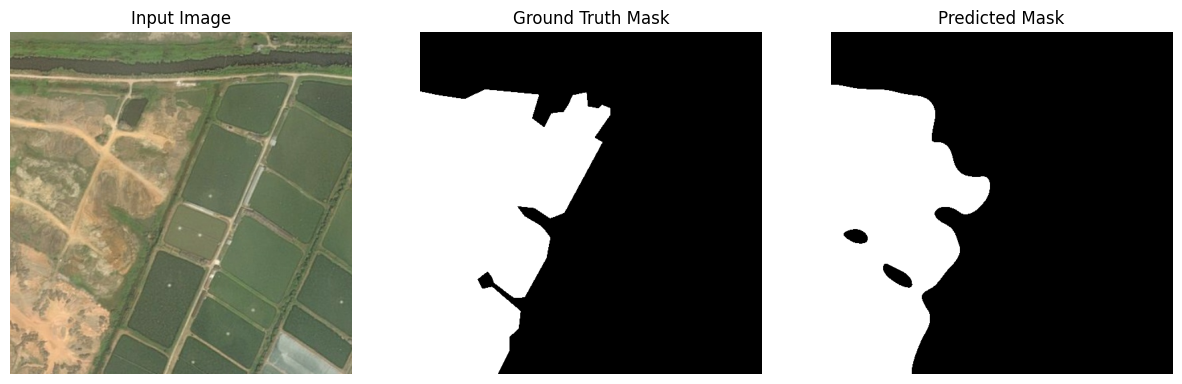

In [17]:
# Print Sample one
IMAGE_PATH = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\test\images\2.jpg'
MASK_PATH = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\test\masks\2.png'
RESULT_DIR = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result'


# Run the function to save and display results
save_and_display_results(model, IMAGE_PATH, MASK_PATH, RESULT_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH))

In [4]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import jaccard_score

# Parameters for the test set
IMG_HEIGHT, IMG_WIDTH = 512, 512

# Load the saved model
model = tf.keras.models.load_model('deeplabv3_model.h5',
                                   custom_objects={'MeanIoU': tf.keras.metrics.MeanIoU})

# Function to preprocess images and masks
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension


def preprocess_mask(mask_path, target_size):
    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
    mask = np.where(mask > 0.5, 1, 0)  # Binarize
    return mask.squeeze()  # Remove single channel dimension


# Compute IoU for a single image
def compute_iou_for_image(model, image_path, mask_path):
    # Preprocess image and mask
    image = preprocess_image(image_path, (IMG_HEIGHT, IMG_WIDTH))
    ground_truth = preprocess_mask(mask_path, (IMG_HEIGHT, IMG_WIDTH))

    # Predict mask
    prediction = model.predict(image)
    prediction = (prediction.squeeze() > 0.5).astype(np.uint8)  # Threshold prediction

    # Flatten predictions and ground truth
    prediction_flat = prediction.flatten()
    ground_truth_flat = ground_truth.flatten()

    # Compute IoU
    iou = jaccard_score(ground_truth_flat, prediction_flat, average='binary')
    print(f"IoU for {os.path.basename(image_path)}: {iou:.4f}")
    return iou


# Specify the paths for the image and mask
IMAGE_PATH = 'dataset/test/images/2.jpg'
MASK_PATH = 'dataset/test/masks/2.png'

# Compute IoU for the specific image
compute_iou_for_image(model, IMAGE_PATH, MASK_PATH)


1/1 [==============================] - 1s 663ms/step
IoU for 2.jpg: 0.8202


0.8202351634555024

## Visualize Sample 2

1/1 [==============================] - 0s 42ms/step
Predicted mask saved to: C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result\265_predicted_mask.png
Ground truth mask saved to: C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result\265_ground_truth_mask.png


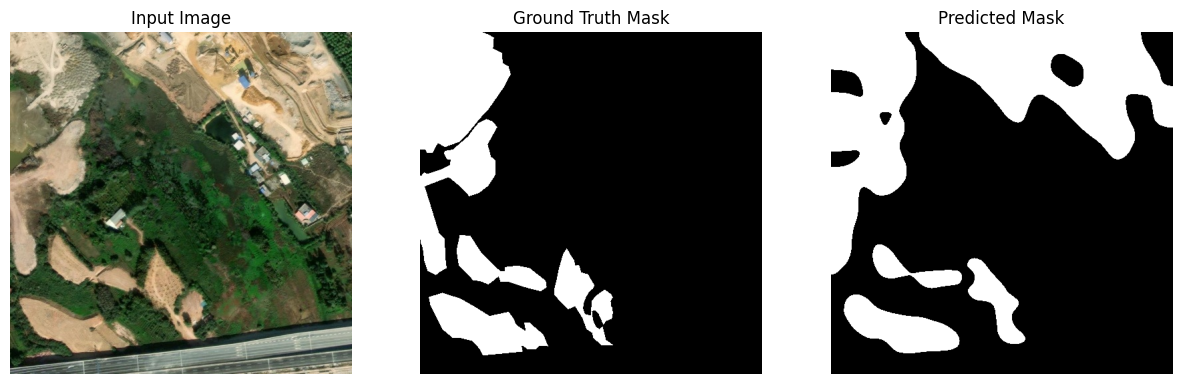

In [18]:
# Print Sample one
IMAGE_PATH = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\test\images\265.jpg'
MASK_PATH = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\test\masks\265.png'
RESULT_DIR = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result'

# Run the function to save and display results
save_and_display_results(model, IMAGE_PATH, MASK_PATH, RESULT_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH))


In [5]:
# Specify the paths for the image and mask
IMAGE_PATH = 'dataset/test/images/265.jpg'
MASK_PATH = 'dataset/test/masks/265.png'

# Compute IoU for the specific image
compute_iou_for_image(model, IMAGE_PATH, MASK_PATH)


1/1 [==============================] - 0s 33ms/step
IoU for 265.jpg: 0.4370


0.4370282171099928

## Visualize example 3
### In this example, there are no landfills in the area, as indicated by the ground truth mask. The model accurately predicted this outcome, as shown in the predicted mask.

1/1 [==============================] - 0s 33ms/step
Predicted mask saved to: C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result\co1373_predicted_mask.png
Ground truth mask saved to: C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result\co1373_ground_truth_mask.png


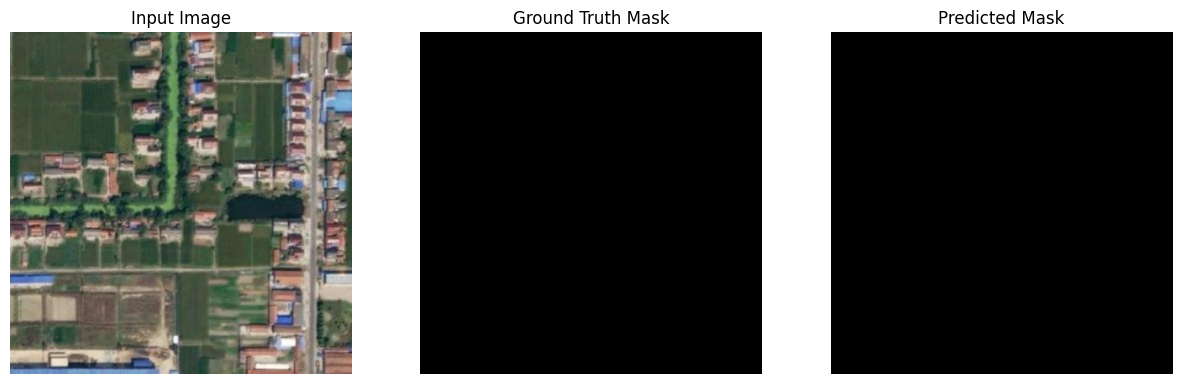

In [19]:
# Print Sample one
IMAGE_PATH = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\test\images\co1373.jpg'
MASK_PATH = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\test\masks\co1373.png'
RESULT_DIR = r'C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\dataset\result'

# Run the function to save and display results
save_and_display_results(model, IMAGE_PATH, MASK_PATH, RESULT_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH))

